<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Lab_5/Sesi%C3%B3n%201/Laboratorio_IV_Sesion_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# **Machine Learning Techniques - ISIS4219**

Segundo Semestre - 2021

## **Objetivos**<a name="id1"></a>
- Entrar en materia con las Redes Neuronales Convolucionales.
- Conocer tácticas de aprendizaje y mejoras en el entrenamiento.
- Familiarizarse con el aprendizaje por transferencia.
- Entrar en más profundidad con los gadgets de `TensorFlow` y `Keras`.
- Aprender arquitecturas neuronales, sus ventajas y desventajas.

## **Problema**<a name="id2"></a>
- En un cultivo de gran área se busca hacer la clasificación de 9 especies que allí habitan, dado que hacen daño al ecosistema. El objetivo de la clasificación es identificar correctamente la planta, para respectiva su extracción.

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_12()

shred: setup_colab.py: failed to open for writing: No such file or directory
shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


  0%|          | 0/1 [00:00<?, ?KB/s]

Util Functions Downloaded Successfully


  0%|          | 0/491000.0 [00:00<?, ?KB/s]

  0%|          | 0/17509 [00:00<?, ?it/s]

Deleting File...


  0%|          | 0/63 [00:00<?, ?KB/s]

Dataset Downloaded Successfully


  0%|          | 0/89000.0 [00:00<?, ?KB/s]

Pretrained Networks Downloaded Successfully
Workshop 12 Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from skimage import io

from utils import general as gen
from utils import tf_utils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

from google.colab import files

from typing import Tuple, List, Union, Optional

### **Carga de Datos**

In [ ]:
data_dir = gen.read_listdir("data")
labels = pd.read_csv("data/labels.csv")

In [ ]:
labels.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


## **Visualización y Análisis Exploratorio**<a name="id4"></a>
- En esta ocación nos vamos a enfrentar al dataset *Deep Weeds*. Que es un dataset que busca clasificar distintas especies de maleza silvestre para efectuar un control de plagas vegetativas más certero. Las especies son las siguientes:
    - Chinee apple
    - Lantana
    - Negative
    - Parkinsonia
    - Parthenium
    - Prickly acacia
    - Rubber vine
    - Siam weed
    - Snake weed


In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(len(data_dir), 9)

In [ ]:
imgs = []
for i in random_sample:
    img = io.imread(data_dir[i])
    imgs.append(img)

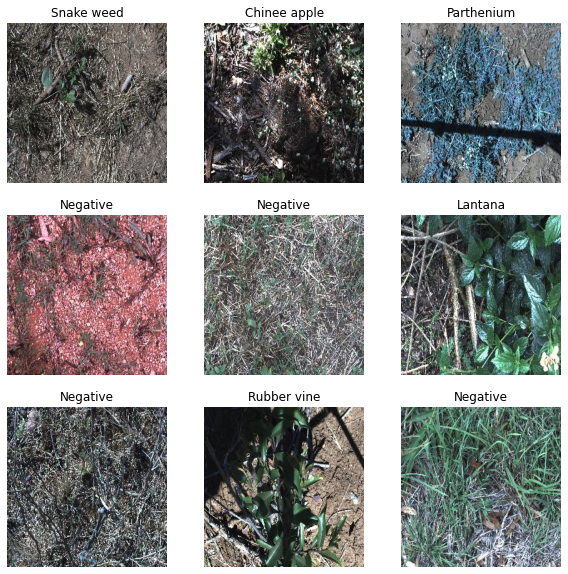

In [ ]:
gen.visualize_subplot(
    imgs, labels.loc[random_sample, "Species"].values, 
    (3, 3), (10, 10),
)

In [ ]:
distribution = labels["Species"].value_counts().sort_index()

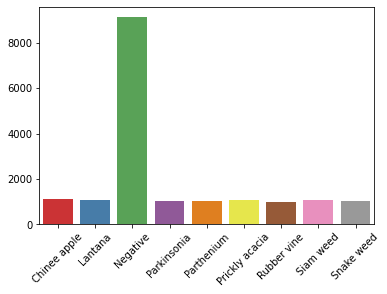

In [ ]:
ax = sns.barplot(x=distribution.index, y=distribution.values, palette="Set1")
ax.set_xticklabels(distribution.index, rotation=45)
plt.show()

In [ ]:
n_samples = 1100

In [ ]:
pos_class = labels.query("Label != 8")
neg_class = labels.query("Label == 8")

In [ ]:
neg_class_downsampled = resample(
    neg_class, replace=False, 
    n_samples=n_samples, 
    random_state=1234
)

In [ ]:
labels_resampled = pd.concat([pos_class, neg_class_downsampled])

In [ ]:
labels_resampled.reset_index(drop=True, inplace=True)

In [ ]:
labels = labels_resampled.copy()

In [ ]:
labels["Species"].value_counts().sort_index()

Chinee apple      1125
Lantana           1064
Negative          1100
Parkinsonia       1031
Parthenium        1022
Prickly acacia    1062
Rubber vine       1009
Siam weed         1074
Snake weed        1016
Name: Species, dtype: int64

In [ ]:
labels["Filename"] = labels["Filename"].apply(
    lambda x: gen.create_and_verify("data", x),
)

In [ ]:
classes = labels.Species.unique()

In [ ]:
labels.head()

,Filename,Label,Species
0,data/20160928-140314-0.jpg,0,Chinee apple
1,data/20160928-140337-0.jpg,0,Chinee apple
2,data/20160928-140731-0.jpg,0,Chinee apple
3,data/20160928-140747-0.jpg,0,Chinee apple
4,data/20160928-141107-0.jpg,0,Chinee apple


## **Preparación de los Datos**<a name="id5"></a>

In [ ]:
list_ds = tf.data.Dataset.from_tensor_slices(
    labels[["Filename", "Species"]].values,
)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
    tf.print(f)

["data/20171113-134252-1.jpg" "Siam weed"]
["data/20170630-154236-0.jpg" "Snake weed"]
["data/20171121-081723-2.jpg" "Siam weed"]
["data/20171121-082214-2.jpg" "Siam weed"]
["data/20171113-145836-3.jpg" "Siam weed"]


In [ ]:
full_train_ds = list_ds.skip(int(len(list_ds) * 0.2))
test_ds = list_ds.take(int(len(list_ds) * 0.2))

In [ ]:
train_ds = full_train_ds.skip(int(len(full_train_ds) * 0.2))
val_ds = full_train_ds.take(int(len(full_train_ds) * 0.2))

In [ ]:
TRAIN_SIZE = len(train_ds)
VAL_SIZE = len(val_ds)
TEST_SIZE = len(test_ds)
BATCH_SIZE = 64

SIZE = (128, 128)

In [ ]:
for f in train_ds.take(5):
    tf.print(f)

["data/20171121-072413-1.jpg" "Siam weed"]
["data/20170920-135932-2.jpg" "Parkinsonia"]
["data/20170811-134343-1.jpg" "Chinee apple"]
["data/20170718-132057-2.jpg" "Snake weed"]
["data/20170410-123853-0.jpg" "Chinee apple"]


In [ ]:
def get_label(path_label: Tuple[tf.Tensor]) -> tf.Tensor:
    one_hot = path_label[1] == classes
    #return tf.argmax(one_hot)
    return tf.convert_to_tensor(one_hot)

In [ ]:
get_label(f)

<tf.Tensor: shape=(9,), dtype=bool, numpy=array([ True, False, False, False, False, False, False, False, False])>

In [ ]:
@tf.function
def process_image(
    path_label: Tuple[tf.Tensor],
) -> Tuple[tf.Tensor]:
    label = get_label(path_label)

    img = tf.io.read_file(path_label[0])
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, SIZE)
    return img, label

def performance(
    dataset: Optional[tf.data.Dataset], 
    train: bool = True,
) -> Optional[tf.data.Dataset]:
    """
    Function to boost dataset load performance
    :param dataset: The dataset to be boosted
    :type dataset: Optional[tf.data.Dataset]
    :param train: Flag to indicate the nature of the dataset
    :type train: bool
    :return: The dataset boosted
    :rtype: Optional[tf.data.Dataset]
    """
    if train:
        # Shuffle the dataset to a fixed buffer sample
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        # The number of batches that will be parallel processed
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Repeat the incidences in the dataset
    dataset = dataset.repeat()
    # Create batches from dataset
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

In [ ]:
for image, label in train_ds.take(5):
    tf.print("Image shape: ", image.shape)
    tf.print("Label: ", label)

In [ ]:
#train_ds = performance(train_ds)
#val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

In [ ]:
for img_batch, label_batch in train_ds.take(1):
    tf.print(img_batch.shape)
    tf.print(label_batch)

TensorShape([64, 128, 128, 3])
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


## **Modelamiento**<a name="id6"></a>
- Inception:

![image](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=es)

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir = "models/weights.h5"

In [ ]:
base_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet", 
    input_shape=(*SIZE, 3),
)
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = tf_utils.DenseBlock(128)(global_avg)
dense_2 = tf_utils.DenseBlock(64)(dense_1)

output = keras.layers.Dense(9, activation="softmax")(dense_2)
model = keras.Model(inputs=base_model.inputs, outputs=output)

lr = 1e-3

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 63, 63, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 63, 63, 32)   0           batch_normalization_192[0][0]    
____________________________________________________________________________________________

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", 
    metrics=["acc"],
)
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 5,
    "validation_data": val_ds,
}

In [ ]:
history = model.fit(train_ds, **params)

Epoch 1/5
95/95 [==============================] - 21s 165ms/step - loss: 2.0556 - acc: 0.2462 - val_loss: 2.7428 - val_acc: 0.1637
Epoch 2/5
95/95 [==============================] - 15s 148ms/step - loss: 1.7872 - acc: 0.3183 - val_loss: 2.0555 - val_acc: 0.2425
Epoch 3/5
95/95 [==============================] - 15s 149ms/step - loss: 1.7140 - acc: 0.3500 - val_loss: 1.9474 - val_acc: 0.2527
Epoch 4/5
95/95 [==============================] - 15s 148ms/step - loss: 1.6431 - acc: 0.3809 - val_loss: 1.9728 - val_acc: 0.2507
Epoch 5/5
95/95 [==============================] - 14s 148ms/step - loss: 1.5950 - acc: 0.3967 - val_loss: 2.9698 - val_acc: 0.1936


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 63, 63, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 63, 63, 32)   0           batch_normalization_192[0][0]    
____________________________________________________________________________________________

### **Adam Optimizer**
- Adam se refiere a *adaptative moment estimation*, y es un optimizador rápido con buen grado de convergencia, es ampliamente usado y es una variación más de SGD.
- He aquí una tabla con las características de los mejores optimizadores.

|Class|Convergence Speed|Convergence Quality|
|---|---|---|
|SGD|*|***|
|SGD(momentum=...)|**|***|
|SGD(momentum=..., nesterov=True)|**|***|
|Adagrad|***|* (Se detiene muy antes)|
|RMSprop|***|** o ***|
|Adam|***|** o ***|
|Nadam|***|** o ***|
|AdaMax|***|** o ***|

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=lr)
metrics = [
    keras.metrics.Precision(name="Precision"), 
    keras.metrics.Recall(name="Recall"), "accuracy",
]
callbacks = [tf_utils.CustomCallback(weights_dir, patience=5)]

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", 
    metrics=metrics,
)

In [ ]:
params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "callbacks": callbacks,
    "epochs": 10,
    "validation_data": val_ds,
}

In [ ]:
history = model.fit(train_ds, **params)

Epoch 1/10
95/95 [==============================] - 41s 422ms/step - loss: 0.8203 - Precision: 0.8496 - Recall: 0.7933 - accuracy: 0.8194 - val_loss: 0.9088 - val_Precision: 0.8207 - val_Recall: 0.7058 - val_accuracy: 0.7466

Best Weights Saved!!
Epoch 2/10
95/95 [==============================] - 41s 423ms/step - loss: 0.1493 - Precision: 0.9689 - Recall: 0.9484 - accuracy: 0.9586 - val_loss: 0.2943 - val_Precision: 0.9383 - val_Recall: 0.8886 - val_accuracy: 0.9083

Best Weights Saved!!
Epoch 3/10
95/95 [==============================] - 41s 422ms/step - loss: 0.1068 - Precision: 0.9749 - Recall: 0.9633 - accuracy: 0.9689 - val_loss: 0.1846 - val_Precision: 0.9601 - val_Recall: 0.9314 - val_accuracy: 0.9450

Best Weights Saved!!
Epoch 4/10
95/95 [==============================] - 40s 422ms/step - loss: 0.0706 - Precision: 0.9833 - Recall: 0.9771 - accuracy: 0.9804 - val_loss: 0.1615 - val_Precision: 0.9559 - val_Recall: 0.9429 - val_accuracy: 0.9490

Best Weights Saved!!
Epoch 5/10
9

## **Predicción**<a name="id7"></a>



In [ ]:
inception_dir = "models/inception.h5"

if os.path.exists(inception_dir):
    model.load_weights(inception_dir)
    print("Weights Loaded!!")

Weights Loaded!!


In [ ]:
for X_batch, y_batch in test_ds.take(1):
    break

In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(len(X_batch), 9)

In [ ]:
y_pred = model.predict(X_batch.numpy()[random_sample])
y_pred = labels["Species"].unique()[y_pred.argmax(axis=1)]

In [ ]:
y_batch = labels["Species"].unique()[
    y_batch.numpy()[random_sample].argmax(axis=1)
]

In [ ]:
titles = [f"{y_t} - {y_p}" for y_t, y_p in zip(y_batch, y_pred)]

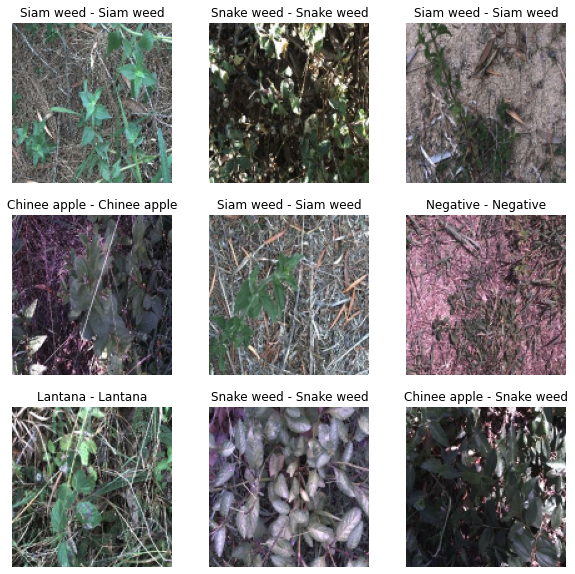

In [ ]:
gen.visualize_subplot(
    X_batch.numpy()[random_sample].astype("uint8"), 
    titles, (3, 3), (10, 10),
)

## **Validación**<a name="id8"></a>

In [ ]:
files.download("models/weights.h5")

In [ ]:
loss, precision, recall, acc = model.evaluate(
    test_ds, steps=TEST_SIZE // BATCH_SIZE,
)

29/29 [==============================] - 5s 172ms/step - loss: 0.1932 - Precision: 0.9527 - Recall: 0.9440 - accuracy: 0.9494


In [ ]:
loss

0.1932450532913208

In [ ]:
precision

0.9526916742324829

In [ ]:
recall

0.943965494632721

In [ ]:
acc

0.9493534564971924

In [ ]:
y_pred = model.predict(test_ds, steps=TEST_SIZE // BATCH_SIZE)

In [ ]:
y_pred = y_pred.argmax(axis=1)

In [ ]:
y_true = np.zeros_like(y_pred)

In [ ]:
index = 0
for label_batch in test_ds.map(lambda x, y: y).repeat(0):
    y_true[BATCH_SIZE * index: BATCH_SIZE * (index + 1)] = label_batch.numpy().argmax(axis=1)
    index += 1

In [ ]:
y_true

array([3, 2, 3, ..., 8, 4, 4])

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

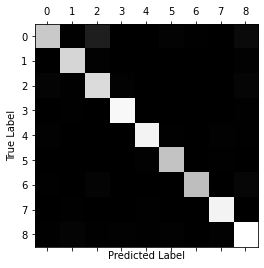

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

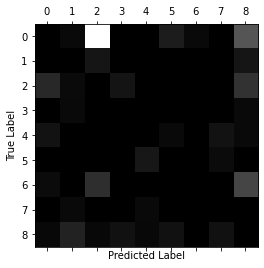

In [ ]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()